#Importing Libraries

In [4]:
import pandas as pd
import random
from keras.layers import Bidirectional
from keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import math
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

#Setting random seeds for reproducibility

In [5]:
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# Loading and preparing the dataset

In [6]:
df = pd.read_csv('7new30.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by='Date').reset_index(drop=True)
df.dropna(inplace=True)

df.info()
df.describe()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1640 entries, 0 to 1639
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               1640 non-null   datetime64[ns]
 1   Price              1640 non-null   float64       
 2   Open               1640 non-null   float64       
 3   High               1640 non-null   float64       
 4   Low                1640 non-null   float64       
 5   Change %           1640 non-null   float64       
 6   GDP                1640 non-null   float64       
 7   Inflation          1640 non-null   float64       
 8   FDI                1640 non-null   float64       
 9   Trade Balance      1640 non-null   float64       
 10  Unemployment Rate  1640 non-null   float64       
 11  Exchange Rate      1640 non-null   float64       
 12  Economic Growth    1640 non-null   float64       
dtypes: datetime64[ns](1), float64(12)
memory usage: 166.7 KB


,0
Date,0
Price,0
Open,0
High,0
Low,0
Change %,0
GDP,0
Inflation,0
FDI,0
Trade Balance,0


# Plot line charts

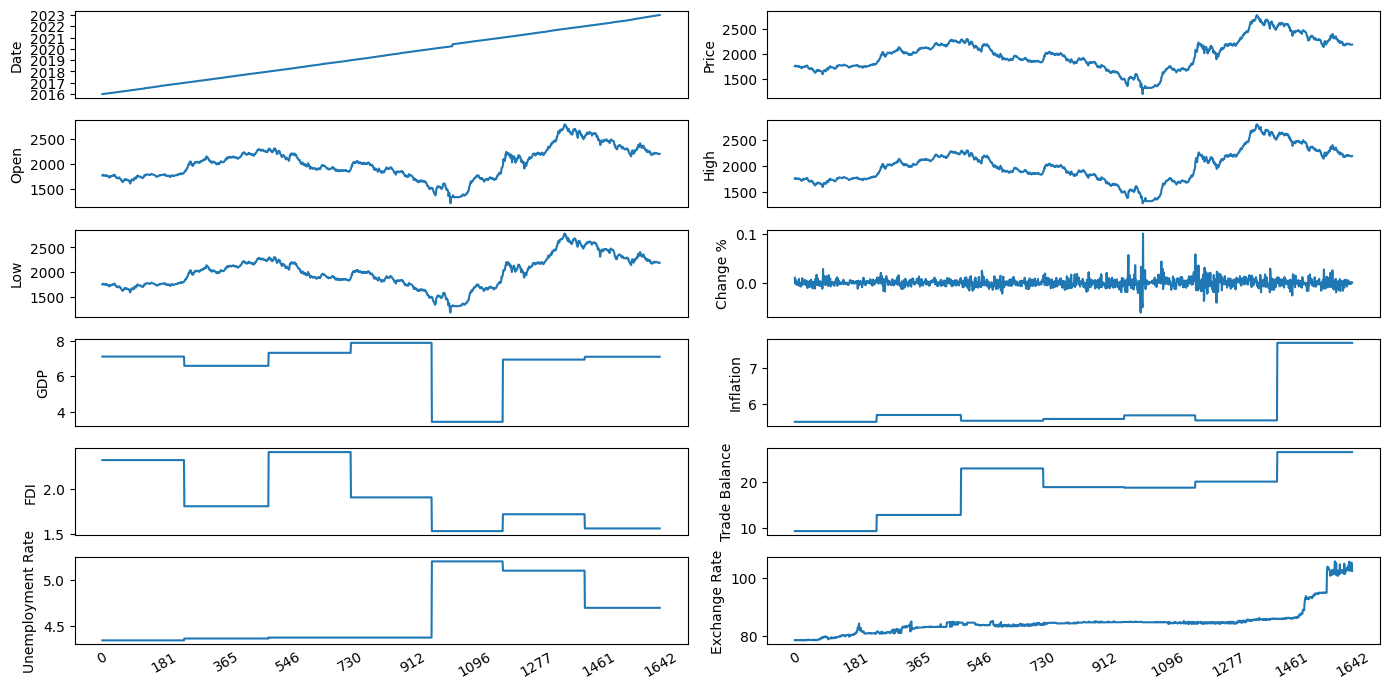

In [7]:
df_plot = df.copy()
ncols = 2
nrows = int(round(df_plot.shape[1] / ncols, 0))
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(14, 7))
for i, ax in enumerate(fig.axes):
    sns.lineplot(data=df_plot.iloc[:, i], ax=ax)
    ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
fig.tight_layout()
plt.show()

# Selecting relevant features for training

In [8]:
FEATURES = ['Price', 'Open', 'High', 'Low', 'GDP','Inflation', 'FDI', 'Trade Balance',
            'Unemployment Rate', 'Exchange Rate', 'Economic Growth']

data_filtered = df[FEATURES]
df.head()

,Date,Price,Open,High,Low,Change %,GDP,Inflation,FDI,Trade Balance,Unemployment Rate,Exchange Rate,Economic Growth
0,2016-01-03,1759.51,1759.51,1759.51,1759.51,0.0103,7.11,5.51,2.33,9.26,4.35,78.425,7.11
1,2016-01-04,1756.56,1756.56,1756.56,1756.56,-0.0017,7.11,5.51,2.33,9.26,4.35,78.435,7.11
2,2016-01-05,1764.07,1764.07,1764.07,1764.07,0.0043,7.11,5.51,2.33,9.26,4.35,78.365,7.11
3,2016-01-06,1774.99,1774.99,1774.99,1774.99,0.0062,7.11,5.51,2.33,9.26,4.35,78.445,7.11
4,2016-01-07,1771.28,1771.28,1771.28,1771.28,-0.0021,7.11,5.51,2.33,9.26,4.35,78.425,7.11


# Normalizing the data using MinMaxScaler

In [9]:
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data_filtered)

# Function to create input sequences for time series modeling

In [10]:
sequence_length = 50

def partition_dataset(sequence_length, data):
    x, y = [], []
    for i in range(sequence_length, len(data)):
        x.append(data[i-sequence_length:i, :])
        y.append(data[i, 0])  # Prediction is based on the 'Price' column
    return np.array(x), np.array(y)

# Dataset partitioning for training and testing

In [11]:
x, y = partition_dataset(sequence_length, data_scaled)
split = math.ceil(0.8 * len(x))
x_train, y_train = x[:split], y[:split]
x_test, y_test = x[split:], y[split:]

# BiLSTM Model Architecture

In [12]:
model = Sequential()
model.add(Bidirectional(LSTM(256, return_sequences=True), input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dropout(0.15))
model.add(Bidirectional(LSTM(128, return_sequences=False)))
#model.add(Dropout(0.1))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


# Compile the model with Adam optimizer and ReduceLROnPlateau callback

In [13]:
optimizer = Adam(clipvalue=1.0)  # Adjust learning rate as needed
model.compile(optimizer=optimizer, loss='mse')

# Define callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=30, verbose=1, mode='min', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

# Model training with validation split

In [14]:
history = model.fit(x_train, y_train, epochs=25, batch_size=32, validation_split=0.1, callbacks=[early_stop, reduce_lr])

Epoch 1/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 32s 723ms/step - loss: 0.0427 - val_loss: 0.0063 - learning_rate: 0.0010
Epoch 2/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 33s 496ms/step - loss: 0.0013 - val_loss: 0.0010 - learning_rate: 0.0010
Epoch 3/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 22s 535ms/step - loss: 6.2402e-04 - val_loss: 0.0012 - learning_rate: 0.0010
Epoch 4/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 19s 490ms/step - loss: 5.5944e-04 - val_loss: 0.0012 - learning_rate: 0.0010
Epoch 5/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 19s 538ms/step - loss: 5.8033e-04 - val_loss: 0.0017 - learning_rate: 0.0010
Epoch 6/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 533ms/step - loss: 4.8321e-04 - val_loss: 0.0011 - learning_rate: 2.0000e-04
Epoch 7/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 19s 514ms/step - loss: 3.8097e-04 - val_loss: 0.0011 - learning_rate: 2.0000e-04
Epoch 8/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 19s 487ms/step - loss: 3.9073e-04 - val_loss: 0.0011 - learning_rate: 2.0000e-04
Epoch 9/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 21s 505ms/step - loss: 3.5736e-04 - va

# Plotting training and validation loss

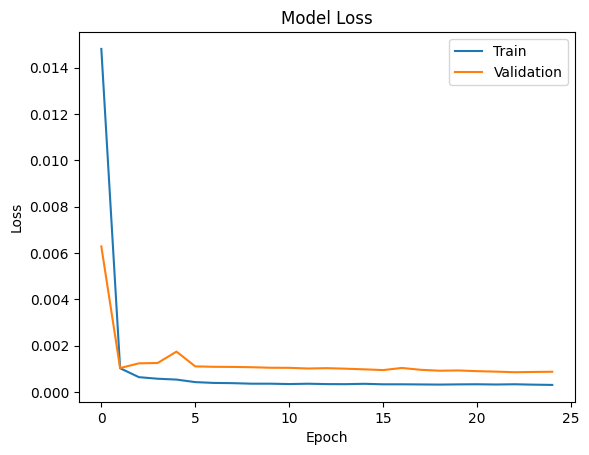

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Prediction and inverse transformation

In [16]:
y_pred_scaled = model.predict(x_test)
y_pred = scaler.inverse_transform(np.concatenate((y_pred_scaled, x_test[:, -1, 1:]), axis=1))[:, 0]
y_test_unscaled = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), x_test[:, -1, 1:]), axis=1))[:, 0]

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 190ms/step


# Evaluation metrics: MSE, RMSE, MAE, MAPE

In [17]:
mse = mean_squared_error(y_test_unscaled, y_pred)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_test_unscaled - y_pred))
mape = np.mean(np.abs((y_test_unscaled - y_pred) / y_test_unscaled)) * 100

print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')
print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')

Mean Squared Error (MSE): 6118.85
Root Mean Squared Error (RMSE): 78.22
Mean Absolute Error (MAE): 69.98
Mean Absolute Percentage Error (MAPE): 2.91%


# Accuracy Calculation (based on trend range)

In [18]:
absolute_difference = np.abs(y_test_unscaled - y_pred)

# Calculate the mean absolute difference
mean_absolute_difference = np.mean(absolute_difference)

# Calculate the range of prices
price_range = np.max(y_test_unscaled) - np.min(y_test_unscaled)

# Calculate accuracy in percentage
accuracy_percentage = (1 - (mean_absolute_difference / price_range)) * 100

print(f'Accuracy of Predicted Prices: {accuracy_percentage:.2f}%')

Accuracy of Predicted Prices: 89.11%


# Visualization: True vs Predicted Price Trend

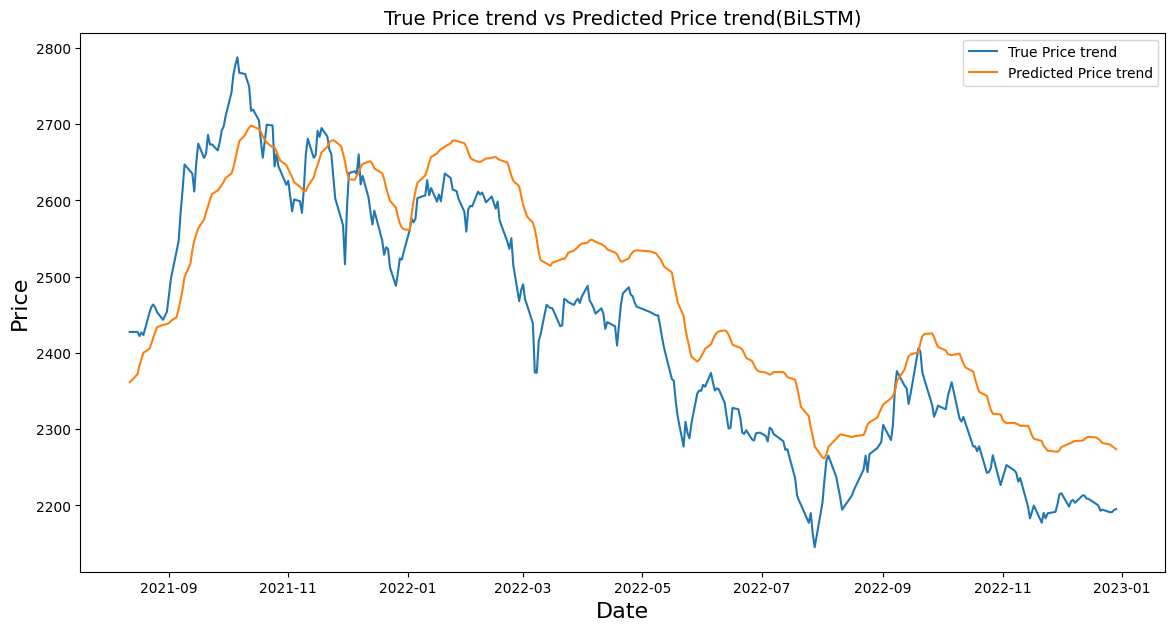

In [19]:
plt.figure(figsize=(14, 7))
plt.plot(df['Date'].iloc[-len(y_test_unscaled):], y_test_unscaled, label='True Price trend')
plt.plot(df['Date'].iloc[-len(y_pred):], y_pred, label='Predicted Price trend')
plt.title('True Price trend vs Predicted Price trend(BiLSTM)', fontsize=14)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Price', fontsize=16)
plt.legend()
plt.show()